# Train

In [5]:
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
!pip install segmentation_models==1.0.1
!pip install tensorflow==2.3.1
!pip install keras==2.4.3
!pip install tensorflow_addons
!pip install albumentations
!pip install imagecodecs

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
     |████████████████████████████████| 17.9 MB 10.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [6]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [7]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import cv2
import json
import time
import random
import numpy as np
import pandas as pd 
import tifffile as tiff
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
print('tensorflow version:', tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)
#policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
#tf.keras.mixed_precision.experimental.set_policy(policy)
pd.set_option('display.max_columns', None)

Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.3.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [10]:
VER = 'v2'
PARAMS = {
    'version': VER,
    'folds': 4,
    'img_size': 256,
    'resize': 1,
    'batch_size': 20,
    'epochs': 1000,
    'patience': 5,
    'decay': False,
    'backbone': 'efficientnetb2', # efficientnetbX, resnet34/50, resnext50, seresnet34, seresnext50
    'bce_weight': 1.,
    'loss': 'bce_jaccard_loss', # bce_jaccard_loss bce_dice
    'seed': 2020,
    'split': 'group',
    'mirror': False,
    'aughard': True,
    'umodel': 'unet',
    'pseudo': '',
    'lr': .0002,
    'shift': False,
    'external': '', # 'None' otherwise
    'comments': ''
}
DATA_PATH = '../data'
resize = PARAMS['resize']
size = PARAMS['img_size']
ext = PARAMS['external']
pseudo = PARAMS['pseudo']
if PARAMS['pseudo']:
    IMGS_PATH = f'{DATA_PATH}/tiles_r{resize}_s{size}_{pseudo}/'
    MSKS_PATH = f'{DATA_PATH}/masks_r{resize}_s{size}_{pseudo}/'
else:
    if PARAMS['shift']:
        if ext:
            IMGS_PATH = f'{DATA_PATH}/tiles_r{resize}_s{size}_shft_{ext}/'
            MSKS_PATH = f'{DATA_PATH}/masks_r{resize}_s{size}_shft_{ext}/'
        else:
            IMGS_PATH = f'{DATA_PATH}/tiles_r{resize}_s{size}_shft/'
            MSKS_PATH = f'{DATA_PATH}/masks_r{resize}_s{size}_shft/'
    else:
        if ext:
            IMGS_PATH = f'{DATA_PATH}/tiles_r{resize}_s{size}_{ext}/'
            MSKS_PATH = f'{DATA_PATH}/masks_r{resize}_s{size}_{ext}/'
        else:
            IMGS_PATH = f'{DATA_PATH}/tiles_v2_1500_to256/'
            MSKS_PATH = f'{DATA_PATH}/masks_v2_1500_t0256/'
MDLS_PATH = f'../models_{VER}'
if not os.path.exists(MDLS_PATH):
    os.mkdir(MDLS_PATH)
with open(f'{MDLS_PATH}/params.json', 'w') as file:
    json.dump(PARAMS, file)
if not PARAMS['mirror']:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    STRATEGY = tf.distribute.get_strategy() 
else:
    STRATEGY = tf.distribute.MirroredStrategy()
    
def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_all(PARAMS['seed'])
start_time = time.time()

# Utils

In [11]:
if PARAMS['aughard']:
    aug = albu.Compose([
        albu.OneOf([
            albu.RandomBrightness(limit=.2, p=1), 
            albu.RandomContrast(limit=.2, p=1), 
            albu.RandomGamma(p=1)
        ], p=.5),
        albu.OneOf([
            albu.Blur(blur_limit=3, p=1),
            albu.MedianBlur(blur_limit=3, p=1)
        ], p=.1),
        albu.RandomRotate90(p=.5),
        albu.HorizontalFlip(p=.5),
        albu.VerticalFlip(p=.5),
        albu.ShiftScaleRotate(p=.25)
    ])
else:
    aug = albu.Compose([
        albu.OneOf([
            albu.RandomBrightness(limit=.2, p=1), 
            albu.RandomContrast(limit=.2, p=1), 
            albu.RandomGamma(p=1)
        ], p=.5),
        albu.RandomRotate90(p=.25),
        albu.HorizontalFlip(p=.25),
        albu.VerticalFlip(p=.25)
    ])

In [12]:
class DataGenKid(Sequence):
    
    def __init__(self, imgs_path, msks_path, imgs_idxs, img_size,
                 batch_size=32, mode='fit', shuffle=False, 
                 aug=None, resize=None):
        self.imgs_path = imgs_path
        self.msks_path = msks_path
        self.imgs_idxs = imgs_idxs
        self.img_size = img_size
        self.batch_size = batch_size
        self.mode = mode
        self.shuffle = shuffle
        self.aug = aug
        self.resize = resize
        self.on_epoch_end()
#         self.imgs_lst = os.listdir(imgs_path).sort()
#         self.msks_lst = os.listdir(msks_path).sort()
        
    def __len__(self):
        return int(np.floor(len(self.imgs_idxs) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgs_idxs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_size = min(self.batch_size, len(self.imgs_idxs) - index*self.batch_size)
        X = np.zeros((batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        imgs_batch = self.imgs_idxs[index * self.batch_size : (index+1) * self.batch_size]
        if self.mode == 'fit':
            y = np.zeros((batch_size, self.img_size, self.img_size), dtype=np.float32)
            for i, img_idx in enumerate(imgs_batch):
                X[i, ], y[i] = self.get_tile(img_idx)
            return X, y
        elif self.mode == 'predict':
            for i, img_idx in enumerate(imgs_batch):
                X[i, ] = self.get_tile(img_idx)
            return X
        else:
            raise AttributeError('fit mode parameter error')
            
    def get_tile(self, img_idx):
        img_path = f'{self.imgs_path}/{img_idx}'
        img = np.load(img_path)
        if img is None:
            print('error load image:', img_path)
#         if self.resize:
#             img = cv2.resize(img, (int(img.shape[1] / self.resize), int(img.shape[0] / self.resize)))
        img = img.astype(np.float32)
        if self.mode == 'fit':
            msk_path = f'{self.msks_path}/{img_idx}'
            msk = np.load(msk_path)
            if msk is None:
                print('error load mask:', msk_path)
#             if self.resize:
#                 msk = cv2.resize(msk, (int(msk.shape[1] / self.resize), int(msk.shape[0] / self.resize)))
            msk = msk.astype(np.float32)
            if self.aug:
                augmented = self.aug(image=img, mask=msk)
                img = augmented['image']
                msk = augmented['mask']
            return img, msk
        else:
            if self.aug:
                img = self.aug(image=img)['image']
            return img

In [ ]:
imgs_idxs = os.listdir(IMGS_PATH)
train_datagen = DataGenKid(
        imgs_path=IMGS_PATH, 
        msks_path=MSKS_PATH, 
        imgs_idxs=imgs_idxs, 
        img_size=PARAMS['img_size'], 
        batch_size=PARAMS['batch_size'], 
        mode='fit', 
        shuffle=True,           
        aug=aug, 
        resize=None
)
val_datagen = DataGenKid(
    imgs_path=IMGS_PATH, 
    msks_path=MSKS_PATH, 
    imgs_idxs=imgs_idxs, 
    img_size=PARAMS['img_size'], 
    batch_size=PARAMS['batch_size'], 
    mode='fit', 
    shuffle=False,           
    aug=None, 
    resize=None
)

test X:  (20, 256, 256, 3)
test y:  (20, 256, 256)


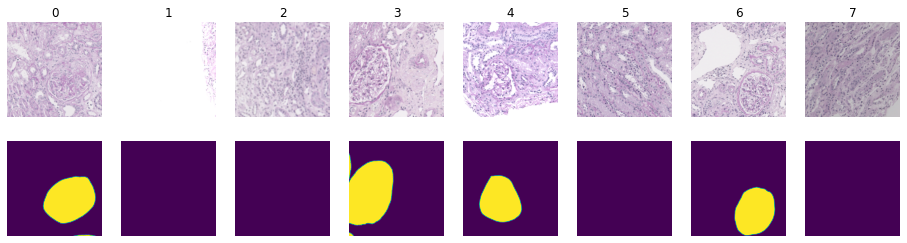

In [8]:
bsize = min(8, PARAMS['batch_size'])
Xt, yt = train_datagen.__getitem__(0)
print('test X: ', Xt.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(16, 4), nrows=2, ncols=bsize)
for j in range(bsize):
    axes[0, j].imshow(Xt[j])
    axes[0, j].set_title(j)
    axes[0, j].axis('off')
    axes[1, j].imshow(yt[j])
    axes[1, j].axis('off')
plt.show()

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return PARAMS['bce_weight'] * binary_crossentropy(y_true, y_pred) + \
        (1 - PARAMS['bce_weight']) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type='bce_dice', 
              umodel='unet', classes=1, lr=.001):
    with STRATEGY.scope():
        if loss_type == 'bce_dice': 
            loss = bce_dice_loss
        elif loss_type == 'bce_jaccard_loss':
            loss = bce_jaccard_loss
        else:
            raise AttributeError('loss mode parameter error')
        if umodel == 'unet':
            model = Unet(backbone_name=backbone, encoder_weights='imagenet',
                         input_shape=input_shape,
                         classes=classes, activation='sigmoid')
        elif umodel == 'fpn':
            model = FPN(backbone_name=backbone, encoder_weights='imagenet',
                        input_shape=input_shape,
                        classes=classes, activation='sigmoid')
        else:
            raise AttributeError('umodel mode parameter error')
        model.compile(
            optimizer=tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate=lr),
                sync_period=max(6, int(PARAMS['patience'] / 4))
            ),
            loss=loss, 
            metrics=[dice_coef]
        )
    return model

In [11]:
def get_lr_callback(batch_size=10, epochs=100, warmup=5, plot=False):
    lr_start = 1e-5
    lr_max = 1e-3
    lr_min = lr_start / 100
    lr_ramp_ep = warmup
    lr_sus_ep = 0
    lr_decay = .95
    
    def lr_scheduler(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay ** (epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
        
    if not plot:
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=False)
        return lr_callback 
    else: 
        return lr_scheduler
    
if PARAMS['decay']:
    lr_scheduler_plot = get_lr_callback(
        batch_size=PARAMS['batch_size'], 
        epochs=PARAMS['epochs'], 
        plot=True
    )
    xs = [i for i in range(PARAMS['epochs'])]
    y = [lr_scheduler_plot(x) for x in xs]
    plt.plot(xs, y)
    plt.title(f'lr schedule from {y[0]:.5f} to {max(y):.3f} to {y[-1]:.8f}')
    plt.show()

# Train

In [12]:
def train_model(mparams, n_fold, train_datagen, val_datagen):
    model = get_model(
        mparams['backbone'], 
        input_shape=(mparams['img_size'], mparams['img_size'], 3),
        loss_type=mparams['loss'],
        umodel=mparams['umodel'],
        lr=mparams['lr']
    )
    checkpoint_path = f'{MDLS_PATH}/model_{n_fold}.hdf5'
    earlystopper = EarlyStopping(
        monitor='val_dice_coef', 
        patience=mparams['patience'], 
        verbose=0,
        restore_best_weights=True,
        mode='max'
    )
    lrreducer = ReduceLROnPlateau(
        monitor='val_dice_coef', 
        factor=.1, 
        patience=int(mparams['patience'] / 2), 
        verbose=0, 
        min_lr=1e-7,
        mode='max'
    )
    checkpointer = ModelCheckpoint(
        checkpoint_path, 
        monitor='val_dice_coef', 
        verbose=0, 
        save_best_only=True,
        save_weights_only=True, 
        mode='max'
    )
    callbacks = [earlystopper, checkpointer]
    if mparams['decay']:
        callbacks.append(get_lr_callback(mparams['batch_size']))
        print('lr warmup and decay')
    else:
        callbacks.append(lrreducer)
        print('lr reduce on plateau')
    history = model.fit(
        train_datagen,
        validation_data=val_datagen,
        callbacks=callbacks,
        epochs=mparams['epochs'],
        verbose=1
    )
    history_file = f'{MDLS_PATH}/history_{n_fold}.json'
    dict_to_save = {}
    for k, v in history.history.items():
        dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
    with open(history_file, 'w') as file:
        json.dump(dict_to_save, file)
    model.load_weights(checkpoint_path)
    return model, history

In [13]:
for iname in list(set([x[:9] for x in imgs_idxs])):
    print('img name:', iname, 
          '| imgs number:', len([x for x in imgs_idxs if x[:9] == iname]))
if PARAMS['split'] == 'kfold':
    kfold = KFold(n_splits=PARAMS['folds'],     
                  random_state=PARAMS['seed'],
                  shuffle=True).split(imgs_idxs)
elif PARAMS['split'] == 'group':
    grps = [x[:9] for x in imgs_idxs]
    kfold = GroupKFold(n_splits=PARAMS['folds']).split(imgs_idxs, imgs_idxs, grps)
elif PARAMS['split'] == 'twos':
    grps = []
    for x in imgs_idxs:
        if x[:9] in ['e79de561c', '1e2425f28']: grps.append(0)
        elif x[:9] in ['cb2d976f4', 'aaa6a05cc']: grps.append(1)
        elif x[:9] in ['095bf7a1f', '54f2eec69']: grps.append(2)
        else: grps.append(3)
    kfold = GroupKFold(n_splits=PARAMS['folds']).split(imgs_idxs, imgs_idxs, grps)
else:
    raise AttributeError('split mode parameter error')

img name: S 0600256 | imgs number: 489
img name: S 0500018 | imgs number: 492
img name: S 0700215 | imgs number: 111
img name: S 0800091 | imgs number: 203
img name: S 0700272 | imgs number: 158
img name: S 0700350 | imgs number: 588
img name: S 0700334 | imgs number: 276
img name: S 0500178 | imgs number: 234
img name: S 0600150 | imgs number: 132
img name: S 0700123 | imgs number: 117
img name: S 0600367 | imgs number: 662
img name: S 0600467 | imgs number: 641
img name: S 0700239 | imgs number: 236
img name: S 0500300 | imgs number: 94
img name: S 0700470 | imgs number: 91


========== FOLD 0 ==========
train: 3385 | test: 1139
groups train: {'S 0600256', 'S 0500018', 'S 0800091', 'S 0700272', 'S 0700350', 'S 0700334', 'S 0700123', 'S 0600467', 'S 0700239', 'S 0500300', 'S 0700470'} 
groups test: {'S 0600150', 'S 0600367', 'S 0700215', 'S 0500178'}
lr reduce on plateau
Epoch 1/1000
169/169 [==============================] - 49s 291ms/step - loss: 1.1873 - dice_coef: 0.3195 - val_loss: 1.1955 - val_dice_coef: 0.2275
Epoch 2/1000
169/169 [==============================] - 49s 288ms/step - loss: 0.7908 - dice_coef: 0.5205 - val_loss: 0.8412 - val_dice_coef: 0.4437
Epoch 3/1000
169/169 [==============================] - 49s 289ms/step - loss: 0.5544 - dice_coef: 0.6809 - val_loss: 0.6105 - val_dice_coef: 0.6335
Epoch 4/1000
169/169 [==============================] - 49s 289ms/step - loss: 0.3971 - dice_coef: 0.7870 - val_loss: 0.4175 - val_dice_coef: 0.7654
Epoch 5/1000
169/169 [==============================] - 49s 291ms/step - loss: 0.2940 - dice_coef: 0.851

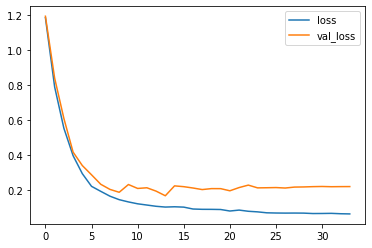

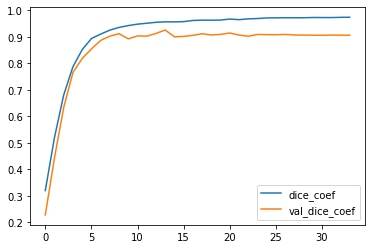

best epoch: 13 | best loss: 0.16738839447498322 | best dice coef: 0.9255252480506897
========== FOLD 1 ==========
train: 3395 | test: 1129
groups train: {'S 0600256', 'S 0500018', 'S 0700215', 'S 0800091', 'S 0500178', 'S 0700350', 'S 0700334', 'S 0600150', 'S 0700123', 'S 0600367', 'S 0700470'} 
groups test: {'S 0700272', 'S 0700239', 'S 0500300', 'S 0600467'}
lr reduce on plateau
Epoch 1/1000
169/169 [==============================] - 50s 296ms/step - loss: 1.0685 - dice_coef: 0.3391 - val_loss: 0.9659 - val_dice_coef: 0.4042
Epoch 2/1000
169/169 [==============================] - 49s 291ms/step - loss: 0.6542 - dice_coef: 0.6025 - val_loss: 0.6613 - val_dice_coef: 0.6196
Epoch 3/1000
169/169 [==============================] - 49s 291ms/step - loss: 0.4023 - dice_coef: 0.7787 - val_loss: 0.5165 - val_dice_coef: 0.7345
Epoch 4/1000
169/169 [==============================] - 49s 291ms/step - loss: 0.2674 - dice_coef: 0.8647 - val_loss: 0.5064 - val_dice_coef: 0.7550
Epoch 5/1000
169/16

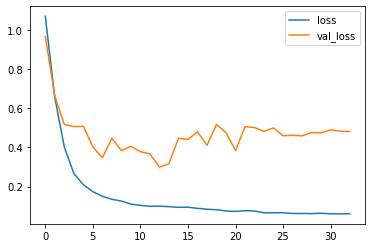

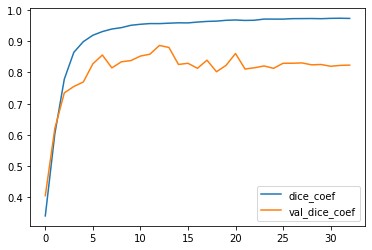

best epoch: 12 | best loss: 0.299281507730484 | best dice coef: 0.8868855237960815
========== FOLD 2 ==========
train: 3366 | test: 1158
groups train: {'S 0600256', 'S 0500018', 'S 0700215', 'S 0500178', 'S 0700272', 'S 0600150', 'S 0700123', 'S 0600367', 'S 0600467', 'S 0700239', 'S 0500300'} 
groups test: {'S 0700350', 'S 0800091', 'S 0700470', 'S 0700334'}
lr reduce on plateau
Epoch 1/1000
168/168 [==============================] - 50s 299ms/step - loss: 1.1490 - dice_coef: 0.3181 - val_loss: 1.3106 - val_dice_coef: 0.2999
Epoch 2/1000
168/168 [==============================] - 49s 292ms/step - loss: 0.7224 - dice_coef: 0.5568 - val_loss: 0.7799 - val_dice_coef: 0.5569
Epoch 3/1000
168/168 [==============================] - 49s 292ms/step - loss: 0.4703 - dice_coef: 0.7344 - val_loss: 0.5654 - val_dice_coef: 0.7252
Epoch 4/1000
168/168 [==============================] - 49s 293ms/step - loss: 0.3036 - dice_coef: 0.8432 - val_loss: 0.4297 - val_dice_coef: 0.8058
Epoch 5/1000
168/168 

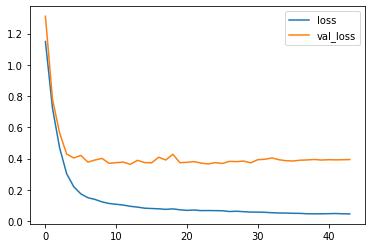

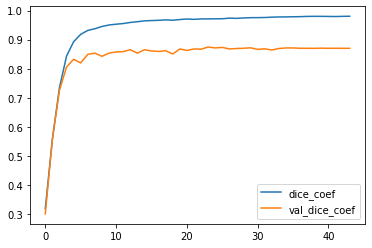

best epoch: 23 | best loss: 0.3661176264286041 | best dice coef: 0.8746072053909302
========== FOLD 3 ==========
train: 3426 | test: 1098
groups train: {'S 0800091', 'S 0700215', 'S 0500178', 'S 0700272', 'S 0700350', 'S 0700334', 'S 0600150', 'S 0600367', 'S 0600467', 'S 0700239', 'S 0500300', 'S 0700470'} 
groups test: {'S 0700123', 'S 0600256', 'S 0500018'}
lr reduce on plateau
Epoch 1/1000
171/171 [==============================] - 51s 300ms/step - loss: 0.9988 - dice_coef: 0.3701 - val_loss: 1.1010 - val_dice_coef: 0.3286
Epoch 2/1000
171/171 [==============================] - 50s 293ms/step - loss: 0.5827 - dice_coef: 0.6577 - val_loss: 0.5862 - val_dice_coef: 0.6605
Epoch 3/1000
171/171 [==============================] - 50s 291ms/step - loss: 0.3578 - dice_coef: 0.8102 - val_loss: 0.3974 - val_dice_coef: 0.7936
Epoch 4/1000
171/171 [==============================] - 50s 292ms/step - loss: 0.2506 - dice_coef: 0.8767 - val_loss: 0.3242 - val_dice_coef: 0.8422
Epoch 5/1000
171/171

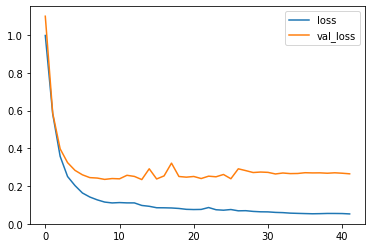

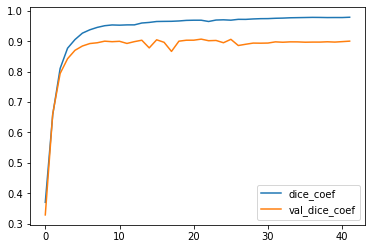

best epoch: 21 | best loss: 0.23976530134677887 | best dice coef: 0.9066104292869568
time elapsed: 133 min 28 sec


In [14]:
epoch_by_folds = []
loss_by_folds = []
dice_coef_by_folds = []

passed = 0
if passed:
    epoch_by_folds.extend([0])
    loss_by_folds.extend([0])
    dice_coef_by_folds.extend([0])
        
for n, (tr, te) in enumerate(kfold):
    print('=' * 10, f'FOLD {n}', '=' * 10)
    X_tr = [imgs_idxs[i] for i in tr]; X_val = [imgs_idxs[i] for i in te]
    print('train:', len(X_tr), '| test:', len(X_val))
    print('groups train:', set([x[:9] for x in X_tr]), 
          '\ngroups test:', set([x[:9] for x in X_val]))
    if passed > 0:
        print('fold done already')
        passed -= 1
    else:
        train_datagen = DataGenKid(
            imgs_path=IMGS_PATH, 
            msks_path=MSKS_PATH, 
            imgs_idxs=X_tr, 
            img_size=PARAMS['img_size'], 
            batch_size=PARAMS['batch_size'], 
            mode='fit', 
            shuffle=True,           
            aug=aug, 
            resize=None
        )
        val_datagen = DataGenKid(
            imgs_path=IMGS_PATH, 
            msks_path=MSKS_PATH, 
            imgs_idxs=X_val, 
            img_size=PARAMS['img_size'], 
            batch_size=PARAMS['batch_size'], 
            mode='fit', 
            shuffle=False,           
            aug=None, 
            resize=None
        )
        model, history = train_model(PARAMS, n, train_datagen, val_datagen)
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.legend()
        plt.show()
        plt.plot(history.history['dice_coef'], label='dice_coef')
        plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
        plt.legend()
        plt.show()
        best_epoch = np.argmax(history.history['val_dice_coef'])
        best_loss = history.history['val_loss'][best_epoch]
        best_dice_coef = history.history['val_dice_coef'][best_epoch]
        print('best epoch:', best_epoch, 
              '| best loss:', best_loss,
              '| best dice coef:', best_dice_coef)
        epoch_by_folds.append(best_epoch)
        loss_by_folds.append(best_loss)
        dice_coef_by_folds.append(best_dice_coef)
        del train_datagen, val_datagen, model; gc.collect()
    
elapsed_time = time.time() - start_time
print(f'time elapsed: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec')

In [ ]:
result = PARAMS.copy()
result['bavg_epoch'] = np.mean(epoch_by_folds)
result['bavg_loss'] = np.mean(loss_by_folds)
result['bavg_dice_coef'] = np.mean(dice_coef_by_folds)
result['dice_by_folds'] = ' '.join([f'{x:.4f}' for x in dice_coef_by_folds])
with open(f'{MDLS_PATH}/params.json', 'w') as file:
    json.dump(result, file)
if not os.path.exists('results.csv'):
    df_save = pd.DataFrame(result, index=[0])
    df_save.to_csv('results.csv', sep='\t')
else:
    df_old = pd.read_csv('results.csv', sep='\t', index_col=0)
    df_save = pd.DataFrame(result, index=[df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index=True)
    df_save.to_csv('results.csv', sep='\t')

In [ ]:
pd.read_csv('results.csv', sep='\t', index_col=0)

# Predict

In [15]:
larger = 4
test_models = []
for n_fold in list(range(PARAMS['folds'])):
    checkpoint_path = f'{MDLS_PATH}/model_{n_fold}.hdf5'
    print(checkpoint_path)
    model_lrg = get_model(
        PARAMS['backbone'], 
        input_shape=(PARAMS['img_size'] * larger, PARAMS['img_size'] * larger, 3),
        loss_type=PARAMS['loss'],
        umodel=PARAMS['umodel']
    )
    model_lrg.load_weights(checkpoint_path) # or .set_weights(model.get_weights()) from smaller model
    test_models.append(model_lrg)

./models_v1/model_0.hdf5
./models_v1/model_1.hdf5
./models_v1/model_2.hdf5
./models_v1/model_3.hdf5


In [19]:
!ls ../data

annotation		 glu_train.csv	      patches
annotation.tar		 masks_v1_1500_t0256  tiles_v1_1500_to256
annotation_xml_rect.zip  masks_v2_1500_t0256  tiles_v2_1500_to256


In [ ]:
img_num = 0
resize = PARAMS['resize']
shft = .6
wnd = PARAMS['img_size'] * larger
img = plt.imread('../data/patches/S 050001807_6_PAS_ind_00_X0_Y0_005727_025687_img.png')
if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
mask = plt.imread('../data/patches/S 050001807_6_PAS_ind_00_X0_Y0_006179_026048_mask.png')
print(img.shape, mask.shape)
img = cv2.resize(img,
                 (img.shape[1] // resize, img.shape[0] // resize),
                 interpolation=cv2.INTER_AREA)
mask = cv2.resize(mask,
                  (mask.shape[1] // resize, mask.shape[0] // resize),
                  interpolation=cv2.INTER_NEAREST)
img = img[int(img.shape[0]*shft) : int(img.shape[0]*shft)+wnd, 
          int(img.shape[1]*shft) : int(img.shape[1]*shft)+wnd, 
          :]
mask = mask[int(mask.shape[0]*shft) : int(mask.shape[0]*shft)+wnd, 
            int(mask.shape[1]*shft) : int(mask.shape[1]*shft)+wnd]
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(img)
plt.imshow(mask, alpha=.4)
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=len(test_models))
for j in range(len(test_models)):
    mask_lrg = test_models[j].predict(img[np.newaxis, ] / 255)
    axes[j].imshow(np.squeeze(mask_lrg))
    axes[j].set_title(f'img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}')
    axes[j].axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(14, 4))
plt.hist(mask_lrg.flatten(), bins=100)
plt.show()

In [ ]:
plt.figure(figsize=(14, 4))
plt.hist(np.where(mask_lrg < 10e-4, np.nan, mask_lrg).flatten(), bins=100)
plt.show()